In [1]:
import pybaseball
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import utils
from sklearn import linear_model
pd.options.mode.chained_assignment = None  # default='warn'
plt.rcParams['text.usetex'] = True
plt.style.use('dark_background')

## Fitting Ballpark Data

Predicting the outcome of batted balls based on launch speed, launch angles, and ballpark.

In [2]:
stats_2022 = pybaseball.statcast('2022-01-01', '2022-12-31')
batted_balls = stats_2022[stats_2022['hc_x'].notnull() & stats_2022['hc_x'].notnull() & stats_2022['launch_angle'].notnull() & stats_2022['launch_speed'].notnull()]
batted_balls["result"] = batted_balls.apply(lambda row: utils.EVENT_VALUE.get(row['events'], 0), axis=1)
batted_balls['horizontal_angle'] = batted_balls.apply(lambda row: utils.horizontal_angle(row['hc_x'], row['hc_y']), axis=1)
sample = batted_balls[['launch_angle', 'launch_speed', 'horizontal_angle', 'result', 'home_team']]
sample

This is a large query, it may take a moment to complete
Skipping offseason dates
Skipping offseason dates


100%|██████████| 246/246 [00:30<00:00,  7.97it/s]


,launch_angle,launch_speed,horizontal_angle,result,home_team
188,53,84.1,51.000493,0,HOU
202,60,99.4,-39.587092,0,HOU
210,14,105.8,-1.561369,1,HOU
217,44,82.2,22.901836,0,HOU
142,43,88.9,-17.387021,0,HOU
...,...,...,...,...,...
182,38,89.9,0.255234,0,COL
360,5,108.4,-24.132217,1,COL
73,-15,86.9,-31.565517,0,COL
124,-22,104.5,33.229834,0,COL


In [3]:
'''
Split data frame into training set and test set
'''
train_ratio = 0.75
total_rows = batted_balls.shape[0]
batted_balls = batted_balls.sample(frac=1) # Shuffle dataframe using sample function
train_size = int(total_rows*train_ratio)
train_df = batted_balls[0:train_size]
test_df = batted_balls[train_size:]

In [4]:
'''
Create feature vector. Each feature is modelled with a polynomial.
The degree of each polynomial was chosen based on sample data shown in 'sample.ipynb'

launch speed - degree 3
vertical launch angle - degree 2
horizontal launch angle - degree 4
'''
X_train, y_train, scaler = utils.statcast_df_to_polynomial_data_matrix(train_df)
X_test, y_test, _ = utils.statcast_df_to_polynomial_data_matrix(test_df, scaler)

Fit a logistic regression model on all batted balls. The logistic regression model will predict the probability a batted ball is an out, single, double, triple, or home run. The data is fit with L2 regularization coefficients ranging from 0.001 to 10000.0.

In [5]:
import warnings
warnings.filterwarnings("ignore") # ignore convergence warnings
alphas = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0]
generic_models = dict()
for alpha in alphas:
    logistic_regression = linear_model.LogisticRegression(C=alpha, multi_class='multinomial', max_iter=1000)
    logistic_regression.fit(X_train, y_train)
    score = logistic_regression.score(X_test, y_test)
    generic_models[str(alpha)] = dict()
    generic_models[str(alpha)]['score'] = score
    generic_models[str(alpha)]['clf'] = logistic_regression
    print(f'L2 regularization coef: {alpha}, score: {score}')

L2 regularization coef: 0.001, score: 0.6872644833185257
L2 regularization coef: 0.01, score: 0.701142734597592
L2 regularization coef: 0.1, score: 0.7111608100242027
L2 regularization coef: 1.0, score: 0.716215802211942
L2 regularization coef: 10.0, score: 0.7165528016911247
L2 regularization coef: 100.0, score: 0.7161545295793634
L2 regularization coef: 1000.0, score: 0.71630771116081
L2 regularization coef: 10000.0, score: 0.7161851658956527


Fit a linear logistic regression model for each ballpark. The L2 regularization parameter has been set to 10.0 based on results of previous cell.

In [6]:
model_by_team = dict()
for team in utils.TEAMS:
    team_train_df = train_df[train_df['home_team'] == team]
    team_X_train, team_y_train, _ = utils.statcast_df_to_polynomial_data_matrix(team_train_df, scaler)
    team_test_df = test_df[test_df['home_team'] == team]
    team_X_test, team_y_test, _ = utils.statcast_df_to_polynomial_data_matrix(team_test_df, scaler)

    model_by_team[team] = dict()
    logistic_regression = linear_model.LogisticRegression(C=100.0, multi_class='multinomial', max_iter=1000)
    logistic_regression.fit(team_X_train, team_y_train)
    score = logistic_regression.score(team_X_test, team_y_test)
    model_by_team[team]
    model_by_team[team]['score'] = score
    model_by_team[team]['clf'] = logistic_regression

Enter a launch speed, vertical launch angle, and horizontal launch angle below. Running the cell will compute the expected outcome of the batted ball in all 30 MLB ballparks using the models trained above. The expected value of the batted ball is computed using the following formula:

$\text{(expected value)} = P(\text{single}) + 2 * P(\text{double}) + 3 * P(\text{triple}) + 4 * P(\text{home run})$

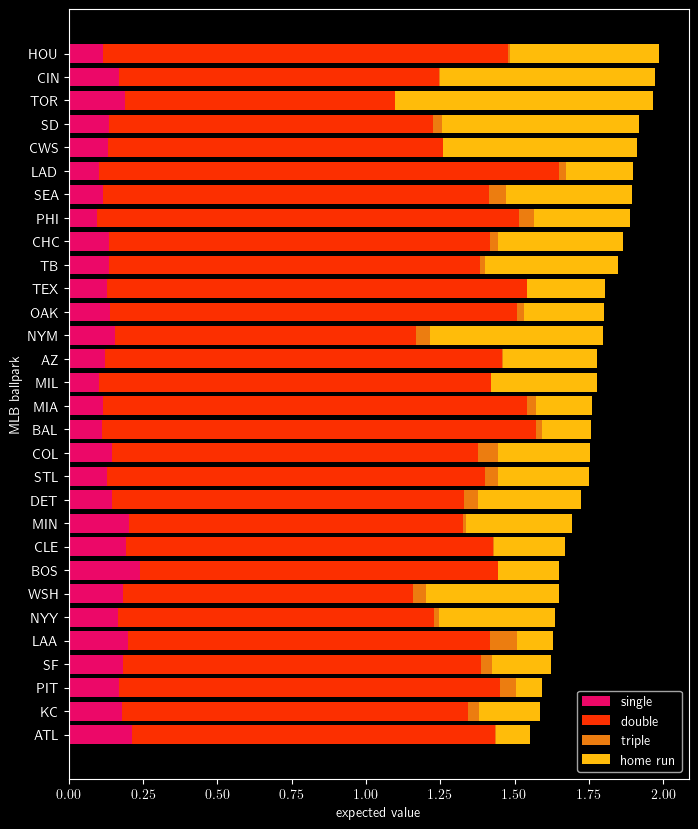

In [7]:
#######################################
####### ENTER TEST DATA HERE ##########
#######################################
test_launch_speed = np.array([110.0])
test_vertical_launch_angle = np.array([15.0])
test_horizontal_launch_angle = np.array([-35.0])
#######################################

test_point, _ = utils.statcast_raw_data_to_polynomial_matrix(test_launch_speed, test_vertical_launch_angle, test_horizontal_launch_angle, scaler)

prb = np.zeros((30, 5))
teams = []
for idx, team in enumerate(utils.TEAMS):
    teams.append(team)
    clf = model_by_team[team]['clf']
    park_prb = clf.predict_proba(test_point)[0]
    prb[idx] = park_prb
zipped_results = zip(teams, prb)
sorted_results = sorted(zipped_results, key=lambda x: x[1][1] + 2.0 * x[1][2] + 3.0 * x[1][3] + 4.0 * x[1][4])

teams, park_prbs = list(zip(*sorted_results))
prb = np.array(park_prbs)

plt.figure(figsize=(8, 10))
plt.barh(teams, prb[:,1], color=utils.EVENT_COLOR['single'], label='single')
plt.barh(teams, prb[:,2]*2, left=prb[:,1], color=utils.EVENT_COLOR['double'], label='double')
plt.barh(teams, prb[:,3]*3, left=prb[:,1]+prb[:,2]*2, color=utils.EVENT_COLOR['triple'], label='triple')
plt.barh(teams, prb[:,4]*4, left=prb[:,1]+prb[:,2]*2+prb[:,3]*3, color=utils.EVENT_COLOR['home_run'], label='home run')
plt.legend()
plt.ylabel('MLB ballpark')
plt.xlabel('expected value')
plt.show()

### Inferring Ballpark from Batted Data

Predicting where each game was played using the batted ball models and Bayes' theorem

In [8]:
guessed_parks = []
actual_parks = []
likelihood_indexes_of_actual_parks = []

for game_pk in batted_balls['game_pk'].unique():
    game_stats = batted_balls[batted_balls['game_pk'] == game_pk]
    X_game, y_game, _ = utils.statcast_df_to_polynomial_data_matrix(game_stats, scaler)

    # log probability any game was played in one of the MLB ballparks
    log_prb_bp = np.log(1 / len(utils.TEAMS))

    # log probability of all batted balls in the game irrespective of ballpark
    generic_log_prb = generic_models['10.0']['clf'].predict_log_proba(X_game)
    log_prb_game = np.sum(np.choose(y_game, generic_log_prb.T))

    prbs = []
    for idx, team in enumerate(utils.TEAMS):
        clf = model_by_team[team]['clf']

        # log probability of all batted balls in the game given the game was played
        # in a particular ballpark
        park_log_prb = clf.predict_log_proba(X_game)
        log_prb_game_given_bp = np.sum(np.choose(y_game, park_log_prb.T))

        # apply Bayes' theorem to determine probability the particular game took
        # place in a particular ballpark
        log_prb_bp_given_game = log_prb_bp + log_prb_game_given_bp - log_prb_game
        prb = np.exp(log_prb_bp_given_game)
        prbs.append((team, prb))

    actual_ballpark = game_stats['home_team'].unique()[0]
    actual_parks.append(actual_ballpark)

    sorted_ballparks_by_likelihood = sorted(prbs, key=lambda x: x[1], reverse=True)
    sorted_ballparks_by_likelihood = [x[0] for x in sorted_ballparks_by_likelihood]
    guessed_ballpark = sorted_ballparks_by_likelihood[0]
    guessed_parks.append(guessed_ballpark)

    guessed_index = sorted_ballparks_by_likelihood.index(actual_ballpark)
    likelihood_indexes_of_actual_parks.append(guessed_index)

### Likelihood of Actual Ballpark from Model
The histogram below indicates the likelihood rank the batted balls model assigned to the ballpark where the game actually took place. For example, rank 1 means the batted balls model predicted the game most likely occurred in the ballpark where the game actually took place. Rank 3 means the batted balls predicted the actual ballpark was only the third most likely ballpark for the game to take place. A good model should have many games with low rank and very few with high rank.

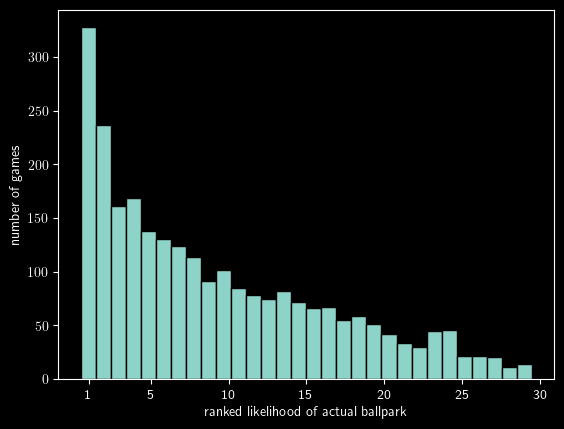

In [9]:
plt.hist(likelihood_indexes_of_actual_parks, 30, edgecolor="black")
plt.ylabel('number of games')
plt.xlabel('ranked likelihood of actual ballpark')
plt.xticks([0.5, 4.5, 9.5, 14.5, 19.5, 24.5, 29.5], labels=[1, 5, 10, 15, 20, 25, 30])
plt.show()

### Confusion Matrix
The below confusion matrix compares the predicted ballpark from the batted balls model against the actual ballpark. This allows us to see which ballparks are most distinguishable, and which ballparks have similar characteristics.

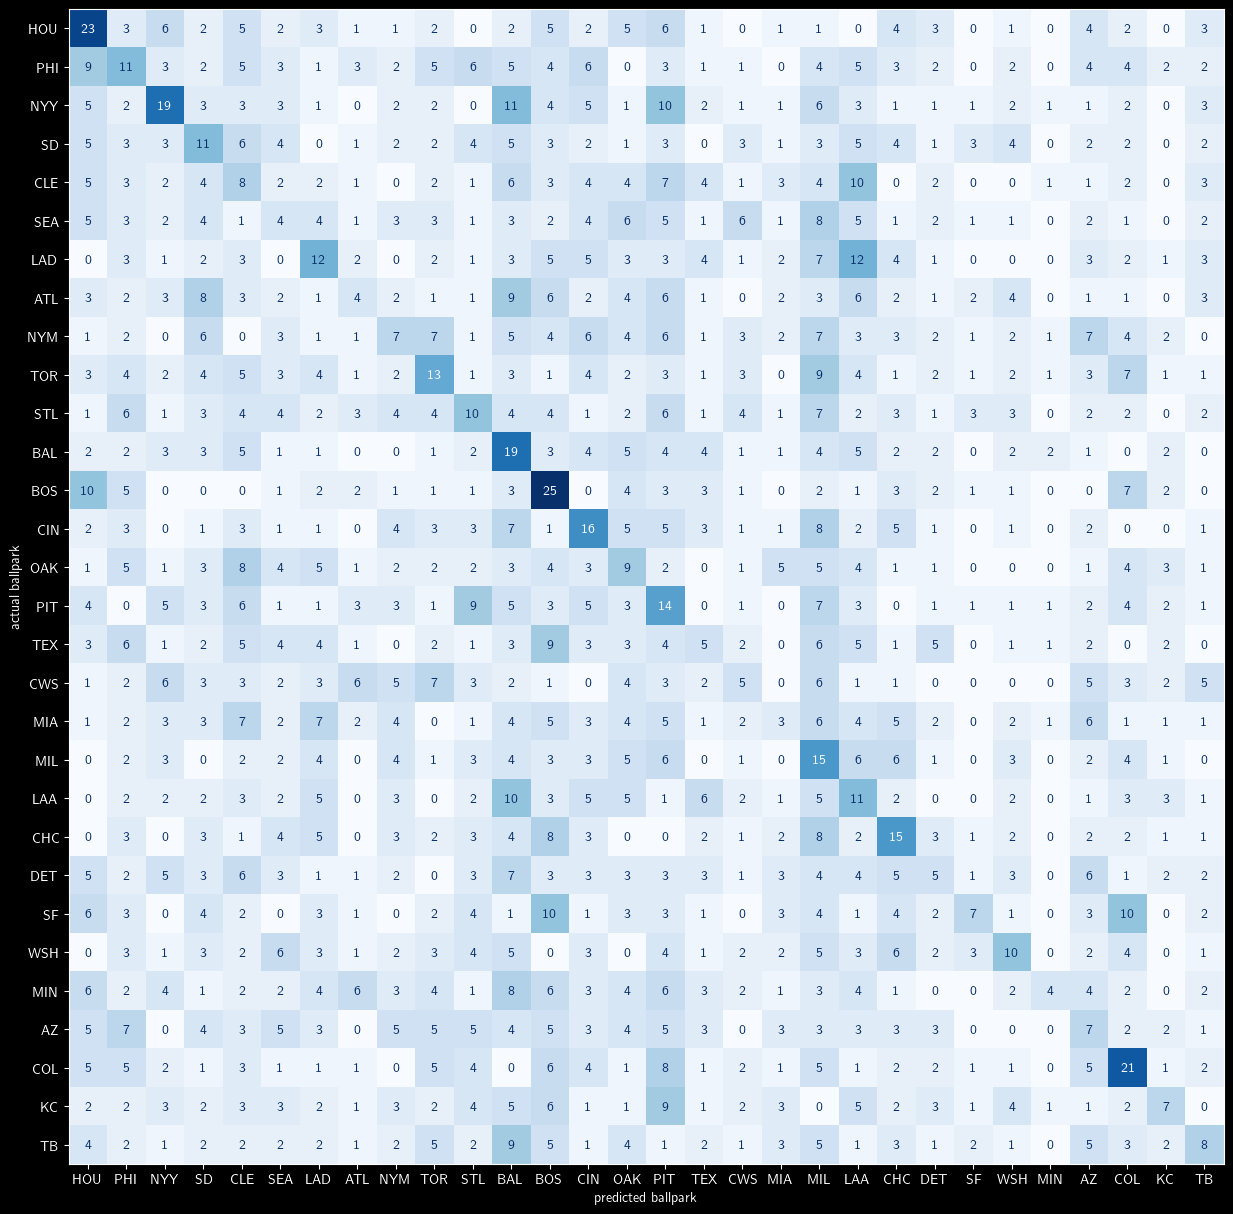

In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(actual_parks, guessed_parks, labels=utils.TEAMS)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=utils.TEAMS)
fig, ax = plt.subplots(figsize=(15,15))
disp.plot(ax=ax, colorbar=False, cmap='Blues')
plt.ylabel('actual ballpark')
plt.xlabel('predicted ballpark')
plt.show()